# **Улучшение качества обучения нейросети на примере датасета персонажей мультфильма Симпсонов**

In [ ]:
!pip install efficientnet-pytorch

  Using cached efficientnet_pytorch-0.7.1.tar.gz (21 kB)
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16429 sha256=a0e890f199c0a2a89dbbe19227776610981b123552d5c161c02c58e6febd4394
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [ ]:
!pip install torch torchvision torchaudio

In [ ]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
sns.set_style(style='whitegrid')
device_num = 0


from torch.optim.lr_scheduler import StepLR, ExponentialLR
from efficientnet_pytorch import EfficientNet


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!mkdir -p data

!cp drive/MyDrive/simpson/simpsons_dataset.zip data/
!cp drive/MyDrive/simpson/test.zip data/

!unzip -o -qq data/simpsons_dataset.zip -d data/
!unzip -o -qq data/test.zip -d data/
!rm -rf data/simpsons_dataset/simpsons_dataset

In [ ]:
# разделим картинки на train и val в отношении 70 на 30 для каждого класса
data_dir = "data/simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 14653
Изображений в val: 6280


In [ ]:

input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [ ]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))


Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


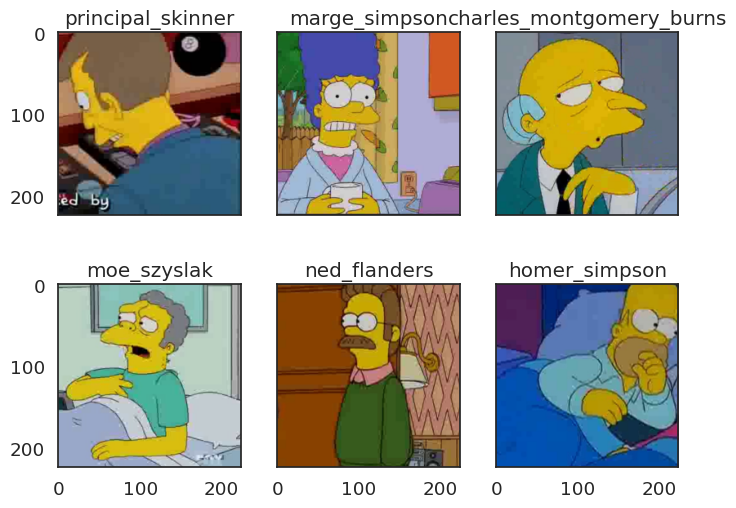

In [ ]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

show_images(val_dataset)


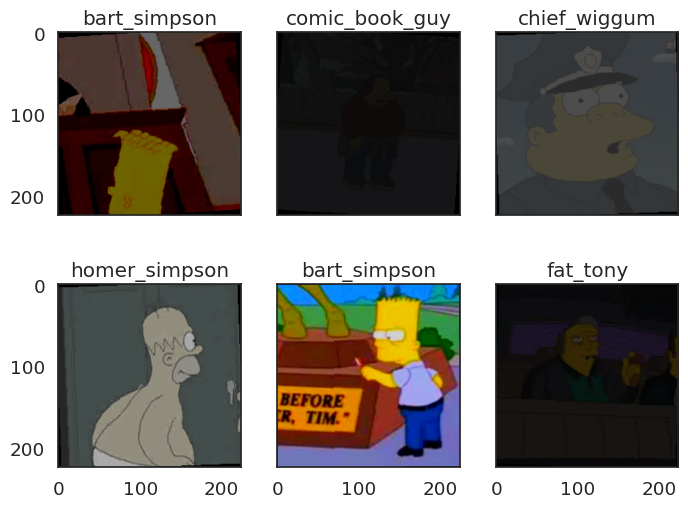

In [ ]:
show_images(train_dataset)

In [ ]:
# Проверка доступности CUDA
if torch.cuda.is_available():
    print('CUDA доступен. Используется версия:', torch.version.cuda)
else:
    print('CUDA недоступен. Используется CPU.')

CUDA недоступен. Используется CPU.


In [ ]:
batch_size = 64


train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

# Модифицикация кода обучения, используя различные типы LR Schedulers из Pytorch.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Эксперимент № 1 С использованием последовательных (цепных планировщиков)

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b0')
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 80], gamma=0.1)

for epoch in range(10):
    model.train()
    train_loss = 0.0

    for input, target in train_batch_gen:
        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_batch_gen)

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for input, target in val_batch_gen:
            output = model(input)
            loss = criterion(output, target)
            val_loss += loss.item()

    val_loss /= len(val_batch_gen)

    print(f'Epoch {epoch+1}/{10}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    scheduler1.step()
    scheduler2.step()

Loaded pretrained weights for efficientnet-b0
Epoch 1/10, Train Loss: 5.6421, Val Loss: 4.6008
Epoch 2/10, Train Loss: 2.2794, Val Loss: 1.2410
Epoch 3/10, Train Loss: 1.0722, Val Loss: 0.7616
Epoch 4/10, Train Loss: 0.7526, Val Loss: 0.5953
Epoch 5/10, Train Loss: 0.6490, Val Loss: 0.5036
Epoch 6/10, Train Loss: 0.5702, Val Loss: 0.4410
Epoch 7/10, Train Loss: 0.5014, Val Loss: 0.3957
Epoch 8/10, Train Loss: 0.4374, Val Loss: 0.3770
Epoch 9/10, Train Loss: 0.4211, Val Loss: 0.3402
Epoch 10/10, Train Loss: 0.4026, Val Loss: 0.3192


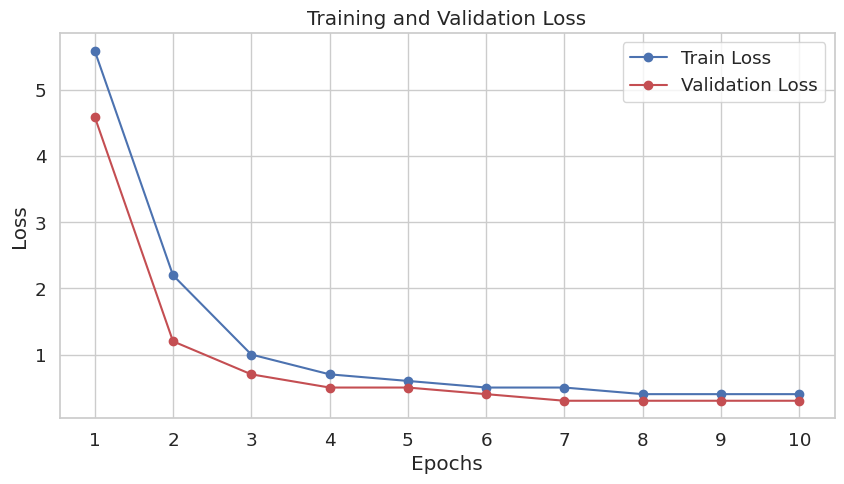

In [ ]:
# Визуализация графика обучения
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='b')
plt.plot(val_losses, label='Validation Loss', color='r')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

### Эксперимент № 2  Планировщик обучения с обновлением оптимизатора (уменьшение скорости обучения каждой группы параметров на гамму каждой эпохи)

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b0')
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


for epoch in range(10):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for input, target in train_batch_gen:
        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()

    train_loss /= len(train_batch_gen)
    train_accuracy = 100 * correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for input, target in val_batch_gen:
            output = model(input)
            loss = criterion(output, target)
            val_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()

    val_loss /= len(val_batch_gen)
    val_accuracy = 100 * correct_val / total_val

    print(f'Epoch {epoch+1}/{10}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    scheduler1.step()


Loaded pretrained weights for efficientnet-b0
Epoch 1/10, Train Loss: 5.6527, Train Accuracy: 12.55%, Val Loss: 4.6236, Val Accuracy: 17.44%
Epoch 2/10, Train Loss: 2.2216, Train Accuracy: 68.12%, Val Loss: 1.2670, Val Accuracy: 70.99%
Epoch 3/10, Train Loss: 1.0826, Train Accuracy: 83.88%, Val Loss: 0.7563, Val Accuracy: 85.11%
Epoch 4/10, Train Loss: 0.7845, Train Accuracy: 87.59%, Val Loss: 0.5774, Val Accuracy: 89.27%
Epoch 5/10, Train Loss: 0.6795, Train Accuracy: 88.18%, Val Loss: 0.5123, Val Accuracy: 90.28%
Epoch 6/10, Train Loss: 0.5543, Train Accuracy: 89.37%, Val Loss: 0.4323, Val Accuracy: 91.59%
Epoch 7/10, Train Loss: 0.5146, Train Accuracy: 90.07%, Val Loss: 0.3992, Val Accuracy: 92.21%
Epoch 8/10, Train Loss: 0.4592, Train Accuracy: 90.50%, Val Loss: 0.3713, Val Accuracy: 92.75%
Epoch 9/10, Train Loss: 0.4178, Train Accuracy: 90.76%, Val Loss: 0.3419, Val Accuracy: 92.82%
Epoch 10/10, Train Loss: 0.4082, Train Accuracy: 91.26%, Val Loss: 0.3256, Val Accuracy: 93.44%


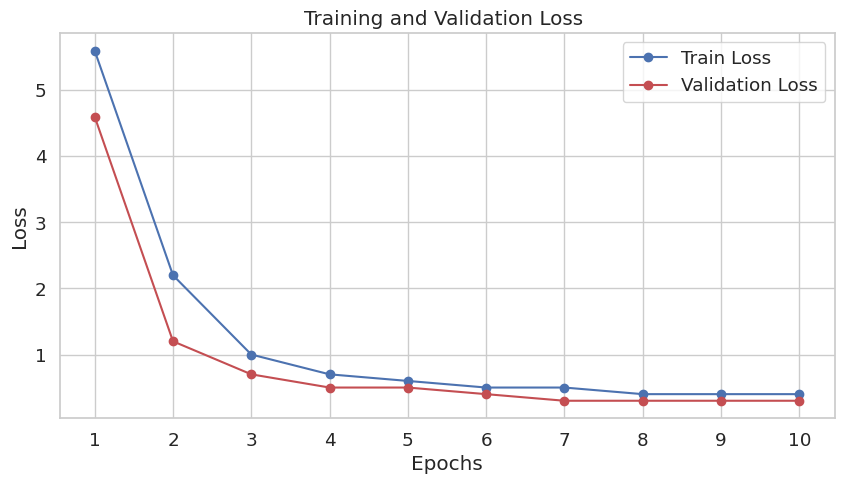

In [ ]:
# Визуализация графика обучения
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='b')
plt.plot(val_losses, label='Validation Loss', color='r')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

**Выводы:**

1. По значению locc:

- В эксперименте № 1 на 10-й эпохе значение locc составляет 0,4026, в то время как в эксперименте № 2 - 0,4082. Это говорит о том, что модель из эксперимента № 1 демонстрирует чуть более высокую точность по сравнению с моделью из эксперимента № 1. Однако разница в значениях locc небольшая.

2. По значению val loss:

- На 10-й эпохе значение val loss для модели из эксперимента № 1 равно 0,3192, в то время как для модели из эксперимента № 2 - 0,3256. Это показывает, что модель из эксперимента № 1 имеет немного меньшую потерю на валидационных данных по сравнению с моделью из эксперимента № 2.

3. Сравнение:

- В целом, можно сказать, что модель в эксперименте № 2, которая использует планировщик обучения с обновлением оптимизатора, всё же показывает немного лучшие результаты (по locc немного лучше, но по потере на валидации немного хуже) по сравнению с моделью в эксперименте № 1, использующей последовательные планировщики.


# EfficientNet с Feature Extractor и  без использования scheduler ExponentialLR до изменения аугментации

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)


model = EfficientNet.from_pretrained('efficientnet-b0')
model.fc = nn.Linear(512, 42)
feature_extractor = FeatureExtractor(model)
feature_extractor = feature_extractor.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(feature_extractor.parameters(), lr=0.01)

for epoch in range(10):
    feature_extractor.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for input, target in train_batch_gen:
        optimizer.zero_grad()
        output = feature_extractor(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()

    train_loss /= len(train_batch_gen)
    train_accuracy = 100 * correct_train / total_train

    feature_extractor.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for input, target in val_batch_gen:
            output = feature_extractor(input)
            loss = criterion(output, target)
            val_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()

    val_loss /= len(val_batch_gen)
    val_accuracy = 100 * correct_val / total_val

    print(f'Epoch {epoch+1}/{10}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')


Loaded pretrained weights for efficientnet-b0
Epoch 1/10, Train Loss: 4.1937, Train Accuracy: 35.05%, Val Loss: 1.7606, Val Accuracy: 65.28%
Epoch 2/10, Train Loss: 0.8683, Train Accuracy: 86.26%, Val Loss: 0.8010, Val Accuracy: 86.27%
Epoch 3/10, Train Loss: 0.4826, Train Accuracy: 90.30%, Val Loss: 0.4905, Val Accuracy: 90.82%
Epoch 4/10, Train Loss: 0.3077, Train Accuracy: 93.64%, Val Loss: 0.3477, Val Accuracy: 93.21%
Epoch 5/10, Train Loss: 0.2120, Train Accuracy: 94.80%, Val Loss: 0.2701, Val Accuracy: 94.68%
Epoch 6/10, Train Loss: 0.1659, Train Accuracy: 95.70%, Val Loss: 0.2217, Val Accuracy: 95.37%
Epoch 7/10, Train Loss: 0.1379, Train Accuracy: 96.26%, Val Loss: 0.1999, Val Accuracy: 96.06%
Epoch 8/10, Train Loss: 0.0908, Train Accuracy: 97.62%, Val Loss: 0.1888, Val Accuracy: 96.06%
Epoch 9/10, Train Loss: 0.0933, Train Accuracy: 97.62%, Val Loss: 0.1751, Val Accuracy: 96.14%
Epoch 10/10, Train Loss: 0.0711, Train Accuracy: 98.21%, Val Loss: 0.1624, Val Accuracy: 96.45%


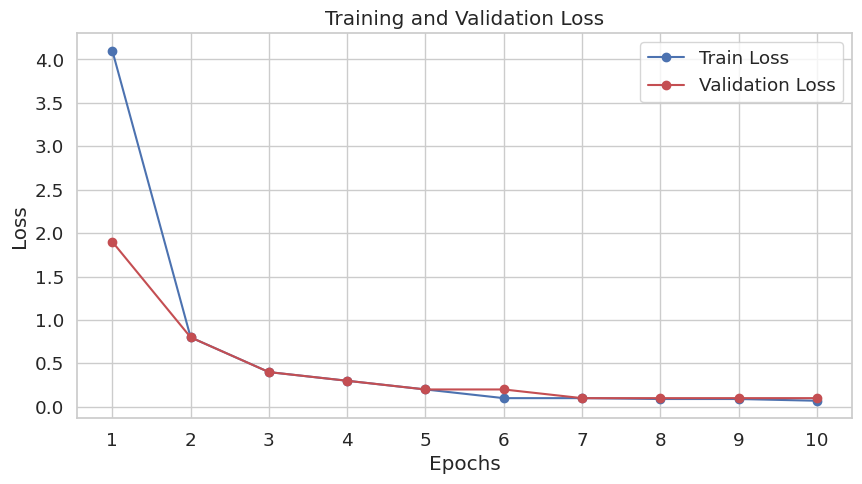

In [ ]:
# Визуализация графика обучения
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='b')
plt.plot(val_losses, label='Validation Loss', color='r')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

#EfficientNet c Feature Extractor + scheduler ExponentialLR до изменения аугментации

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

model = EfficientNet.from_pretrained('efficientnet-b0')
model.fc = nn.Linear(512, 42)
feature_extractor = FeatureExtractor(model)
feature_extractor = feature_extractor.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(feature_extractor.parameters(), lr=0.01)
scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

for epoch in range(10):
    feature_extractor.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for input, target in train_batch_gen:
        optimizer.zero_grad()
        output = feature_extractor(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()

    train_loss /= len(train_batch_gen)
    train_accuracy = 100 * correct_train / total_train

    feature_extractor.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for input, target in val_batch_gen:
            output = feature_extractor(input)
            loss = criterion(output, target)
            val_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()

    val_loss /= len(val_batch_gen)
    val_accuracy = 100 * correct_val / total_val

    print(f'Epoch {epoch+1}/{10}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    scheduler1.step()

Loaded pretrained weights for efficientnet-b0
Epoch 1/10, Train Loss: 4.1921, Train Accuracy: 34.96%, Val Loss: 1.6799, Val Accuracy: 67.67%
Epoch 2/10, Train Loss: 0.8981, Train Accuracy: 85.83%, Val Loss: 0.8352, Val Accuracy: 85.26%
Epoch 3/10, Train Loss: 0.5094, Train Accuracy: 90.27%, Val Loss: 0.5755, Val Accuracy: 89.12%
Epoch 4/10, Train Loss: 0.3617, Train Accuracy: 92.32%, Val Loss: 0.4012, Val Accuracy: 92.05%
Epoch 5/10, Train Loss: 0.2853, Train Accuracy: 93.18%, Val Loss: 0.3391, Val Accuracy: 93.29%
Epoch 6/10, Train Loss: 0.2270, Train Accuracy: 94.54%, Val Loss: 0.2871, Val Accuracy: 94.29%
Epoch 7/10, Train Loss: 0.1802, Train Accuracy: 95.63%, Val Loss: 0.2696, Val Accuracy: 94.44%
Epoch 8/10, Train Loss: 0.1654, Train Accuracy: 95.50%, Val Loss: 0.2477, Val Accuracy: 94.83%
Epoch 9/10, Train Loss: 0.1326, Train Accuracy: 96.79%, Val Loss: 0.2327, Val Accuracy: 95.37%
Epoch 10/10, Train Loss: 0.1496, Train Accuracy: 96.39%, Val Loss: 0.2162, Val Accuracy: 95.29%


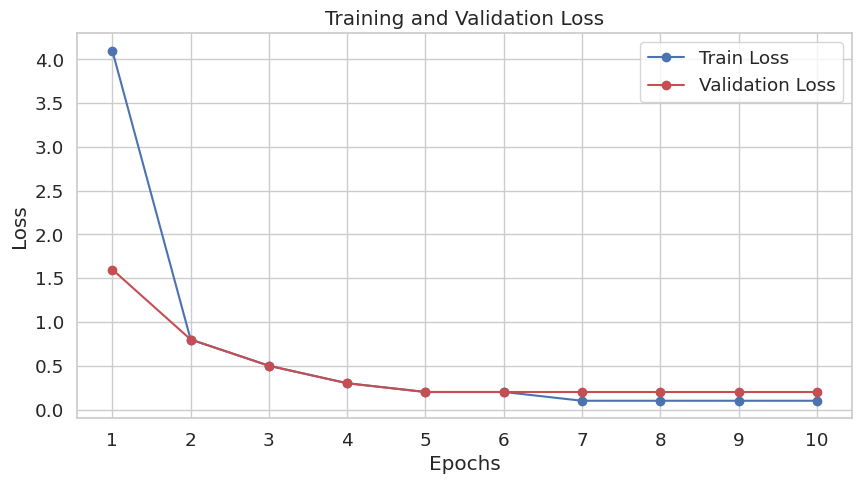

In [ ]:
# Визуализация графика обучения
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='b')
plt.plot(val_losses, label='Validation Loss', color='r')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

#Изменение аугментации

In [ ]:
input_size = 132
train_transform = transforms.Compose([
transforms.Resize(input_size),
transforms.CenterCrop(input_size),
transforms.RandomRotation(90), # Увеличиваем угол поворота до 90 градусов
transforms.RandomPerspective(distortion_scale=0.5, p=1), # Увеличиваем вероятность применения случайной перспективы до 100%
transforms.RandomErasing(p=1, scale=(0.1, 0.5), ratio=(0.5, 5)), # Увеличиваем вероятность стирания до 100% и увеличиваем диапазоны параметров
transforms.GaussianBlur(15), # Увеличиваем силу гауссовского размытия
transforms.ToTensor(),
])

val_transform = transforms.Compose([
transforms.Resize(input_size),
transforms.CenterCrop(input_size),
transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
data_dir,
transform=train_transform,
is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
data_dir,
transform=val_transform,
is_valid_file=lambda x: x in val_files_path
)

# EfficientNet с Feature Extractor и  без использования scheduler ExponentialLR  после изменения аугментации

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)


model = EfficientNet.from_pretrained('efficientnet-b0')
model.fc = nn.Linear(512, 42)
feature_extractor = FeatureExtractor(model)
feature_extractor = feature_extractor.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(feature_extractor.parameters(), lr=0.01)

for epoch in range(10):
    feature_extractor.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for input, target in train_batch_gen:
        optimizer.zero_grad()
        output = feature_extractor(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()

    train_loss /= len(train_batch_gen)
    train_accuracy = 100 * correct_train / total_train

    feature_extractor.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for input, target in val_batch_gen:
            output = feature_extractor(input)
            loss = criterion(output, target)
            val_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()

    val_loss /= len(val_batch_gen)
    val_accuracy = 100 * correct_val / total_val

    print(f'Epoch {epoch+1}/{10}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')


Loaded pretrained weights for efficientnet-b0
Epoch 1/10, Train Loss: 7.1384, Train Accuracy: 10.72%, Val Loss: 9.6868, Val Accuracy: 0.46%
Epoch 2/10, Train Loss: 2.8018, Train Accuracy: 55.51%, Val Loss: 5.3534, Val Accuracy: 24.54%
Epoch 3/10, Train Loss: 1.6689, Train Accuracy: 70.80%, Val Loss: 2.8058, Val Accuracy: 54.63%
Epoch 4/10, Train Loss: 1.0428, Train Accuracy: 81.30%, Val Loss: 1.5405, Val Accuracy: 72.92%
Epoch 5/10, Train Loss: 0.8389, Train Accuracy: 83.15%, Val Loss: 1.2412, Val Accuracy: 78.01%
Epoch 6/10, Train Loss: 0.6472, Train Accuracy: 87.12%, Val Loss: 1.0450, Val Accuracy: 79.01%
Epoch 7/10, Train Loss: 0.5452, Train Accuracy: 87.12%, Val Loss: 0.9389, Val Accuracy: 82.33%
Epoch 8/10, Train Loss: 0.4596, Train Accuracy: 89.41%, Val Loss: 0.8283, Val Accuracy: 83.72%
Epoch 9/10, Train Loss: 0.4333, Train Accuracy: 89.57%, Val Loss: 0.8243, Val Accuracy: 83.72%
Epoch 10/10, Train Loss: 0.3583, Train Accuracy: 90.86%, Val Loss: 0.7915, Val Accuracy: 83.95%


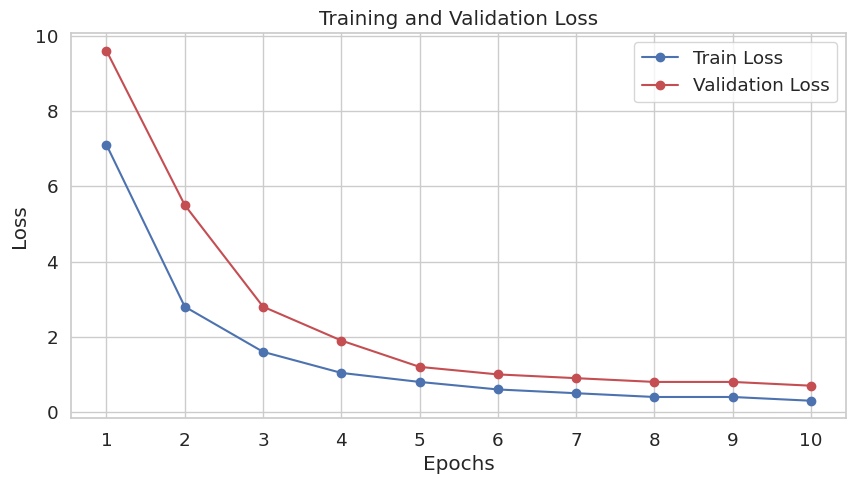

In [ ]:
# Визуализация графика обучения
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='b')
plt.plot(val_losses, label='Validation Loss', color='r')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

#EfficientNet c Feature Extractor + scheduler ExponentialLR после изменения аугментации

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

model = EfficientNet.from_pretrained('efficientnet-b0')
model.fc = nn.Linear(512, 42)
feature_extractor = FeatureExtractor(model)
feature_extractor = feature_extractor.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(feature_extractor.parameters(), lr=0.01)
scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

for epoch in range(10):
    feature_extractor.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for input, target in train_batch_gen:
        optimizer.zero_grad()
        output = feature_extractor(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()

    train_loss /= len(train_batch_gen)
    train_accuracy = 100 * correct_train / total_train

    feature_extractor.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for input, target in val_batch_gen:
            output = feature_extractor(input)
            loss = criterion(output, target)
            val_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()

    val_loss /= len(val_batch_gen)
    val_accuracy = 100 * correct_val / total_val

    print(f'Epoch {epoch+1}/{10}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    scheduler1.step()

Loaded pretrained weights for efficientnet-b0
Epoch 1/10, Train Loss: 7.0656, Train Accuracy: 11.32%, Val Loss: 9.9053, Val Accuracy: 1.00%
Epoch 2/10, Train Loss: 2.8362, Train Accuracy: 55.05%, Val Loss: 5.4559, Val Accuracy: 28.32%
Epoch 3/10, Train Loss: 1.7126, Train Accuracy: 72.29%, Val Loss: 6.6006, Val Accuracy: 19.60%
Epoch 4/10, Train Loss: 1.2830, Train Accuracy: 77.89%, Val Loss: 1.9885, Val Accuracy: 66.74%
Epoch 5/10, Train Loss: 1.0291, Train Accuracy: 81.63%, Val Loss: 1.3188, Val Accuracy: 77.47%
Epoch 6/10, Train Loss: 0.8299, Train Accuracy: 83.58%, Val Loss: 1.1123, Val Accuracy: 80.40%
Epoch 7/10, Train Loss: 0.7056, Train Accuracy: 85.37%, Val Loss: 1.0752, Val Accuracy: 80.48%
Epoch 8/10, Train Loss: 0.6636, Train Accuracy: 85.80%, Val Loss: 1.0065, Val Accuracy: 81.79%
Epoch 9/10, Train Loss: 0.5489, Train Accuracy: 88.15%, Val Loss: 0.9783, Val Accuracy: 81.40%
Epoch 10/10, Train Loss: 0.4976, Train Accuracy: 88.84%, Val Loss: 0.9227, Val Accuracy: 82.41%


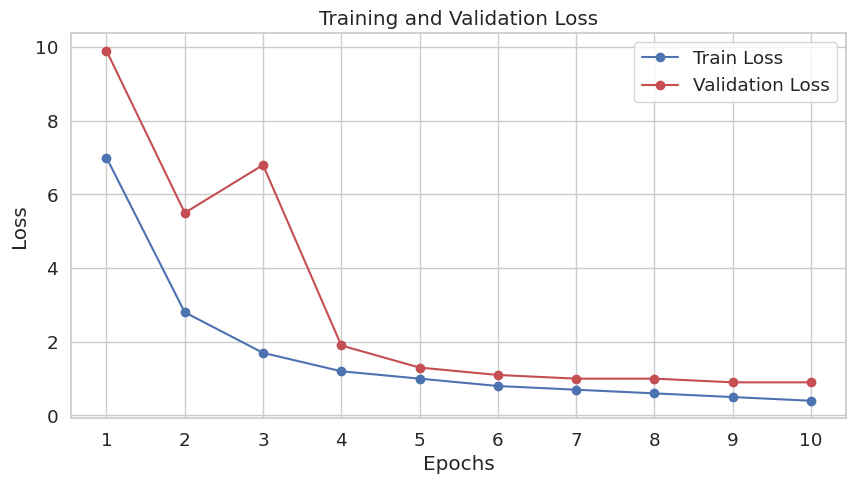

In [ ]:
# Визуализация графика обучения
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='b')
plt.plot(val_losses, label='Validation Loss', color='r')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

**Выводы:**

1. Эффективность модели EfficientNet с Feature Extractor и без использования scheduler ExponentialLR до изменения аугментации значительно улучшилась за 10 эпох обучения. Тренировочная ошибка уменьшилась с 4.1 до 0.07, а ошибка на валидационной выборке с 1.7 до 0.1, что говорит о хорошей обобщающей способности модели.

2. После изменения аугментации, включая поворот на 90 градусов, увеличение случайной перспективы до 100% и увеличение гауссовского размытия, модель EfficientNet с Feature Extractor и без использования scheduler ExponentialLR также продемонстрировала значительное улучшение в процессе обучения. Тренировочная ошибка упала с 7.1 до 0.3, а ошибка на валидационной выборке с 9.6 до 0.7 после 10 эпох обучения.

3. Модель EfficientNet с Feature Extractor + scheduler ExponentialLR также показала хорошие результаты после изменения аугментации. Тренировочная ошибка уменьшилась с 7.0 до 0.4, а ошибка на валидационной выборке с 9.9 до 0.9 после 10 эпох обучения.

Исходя из этих данных, можно сделать вывод, что комбинация EfficientNet с Feature Extractor и использование scheduler ExponentialLR, особенно после изменения аугментации, демонстрирует стабильное и существенное улучшение процесса обучения модели.

#Общие выводы

Исходя из проведенных экспериментов, можно сделать следующие общие выводы:

1. Эффективность модели EfficientNet в сочетании с Feature Extractor и использованием планировщиков обучения является важным аспектом оптимизации процесса обучения.

2. Результаты показывают, что модель EfficientNet с использованием планировщика обучения с обновлением оптимизатора (уменьшение скорости обучения каждой группы параметров на гамму каждой эпохи) демонстрирует чуть более высокую точность (по значению locc) по сравнению с моделью, использующей последовательные планировщики. Однако стоит отметить, что значение потерь на валидационных данных при этом немного выше.

3. После внесения изменений в аугментацию данных (поворот угла на 90 градусов, увеличение случайной перспективы до 100%, увеличение гауссовского размытия), обе модели продемонстрировали существенное улучшение в процессе обучения, что говорит о важности корректного эффективного предобработки данных для обучения моделей.

4. В целом, обе модели показали сопоставимую точность, хотя модель с использованием планировщика обучения с обновлением оптимизатора подтвердила свою эффективность благодаря немного более высокой точности по locc.

5. Вывод: Обучение модели EfficientNet с использованием сочетания Feature Extractor и планировщика обучения с обновлением оптимизатора после изменения аугментации данных демонстрирует более высокую точность и большую склонность к обобщению на новых данных.